# Processing of SCIP features

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [5]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
import pyarrow
from ehv import masking
from ehv.core import plot_gate_czi

## SCIP computed features

In [5]:
data_dir = Path("/home/maximl/scratch/data/CD7/")

In [6]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/")

In [7]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path(data_dir / "results/scip/202202172050/").glob("*.parquet")
], axis=0)
df = df.reset_index(drop=True)

In [8]:
df.shape

(136925, 1290)

In [9]:
df["meta_path"] = df["meta_path"].map(lambda a: "/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/" + os.path.basename(a))

In [87]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/results/scip/202112151458/features.parquet")

## NaN filter

In [10]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(136925, 1290)

In [11]:
df = df.drop(columns=df.columns[df.isna().all(axis=0)])
df.shape

(136925, 1290)

In [12]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]
df = df.drop(columns=cols)
df.shape

(136925, 1290)

In [13]:
cols = df.filter(regex="feat").columns[df.filter(regex="feat").isna().any()]
df = df.drop(columns=cols)
df.shape

(136925, 1290)

# Number of identified regions per channel 

/apps/gent/RHEL8/zen2-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


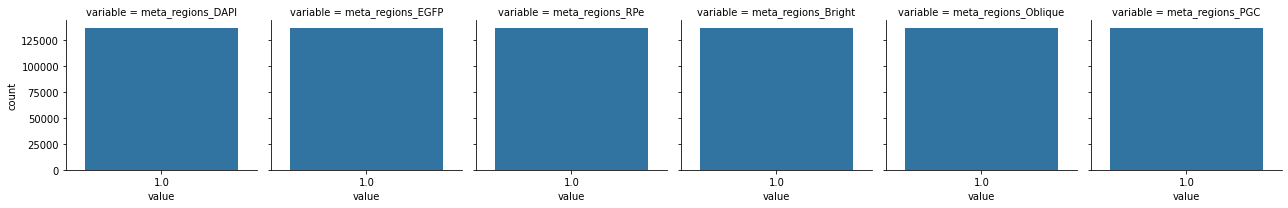

In [14]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_Bright', ylabel='feat_minor_axis_length_Bright'>

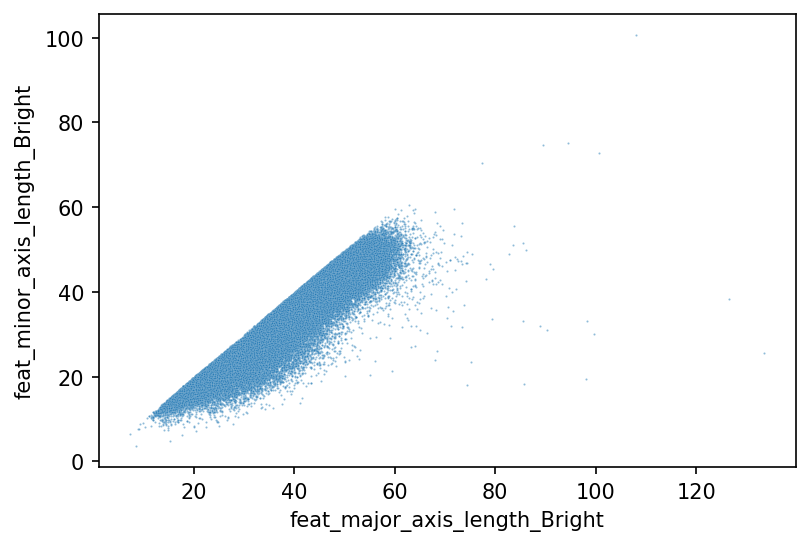

In [15]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_Bright", y="feat_minor_axis_length_Bright", s=1, alpha=0.5)

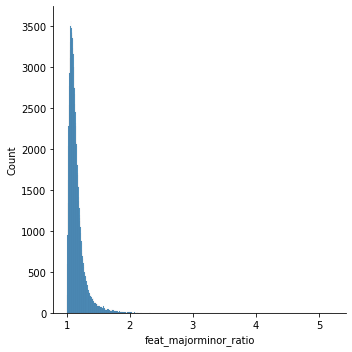

In [16]:
df["feat_majorminor_ratio"] = df["feat_major_axis_length_Bright"] / df["feat_minor_axis_length_Bright"]
ax = seaborn.displot(data=df, x="feat_majorminor_ratio")

34 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
23 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
54 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
35 A7-A7 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
37 A8-A8 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi


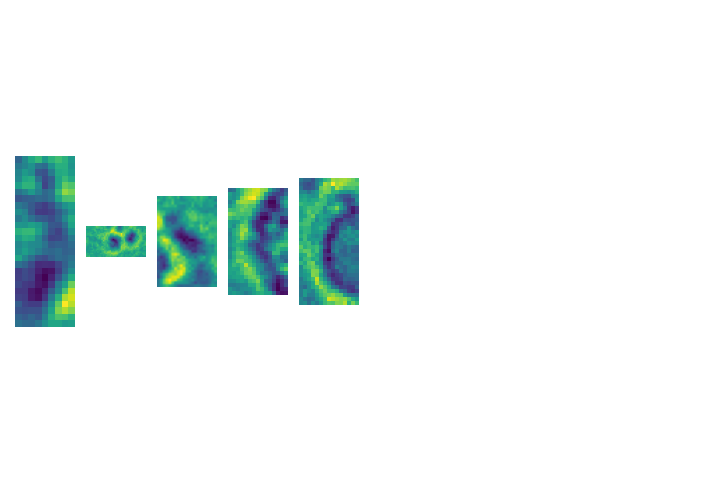

In [17]:
sel1 = df["feat_majorminor_ratio"] > 2
plot_gate_czi(sel1, df, maxn=5, channel=3)

In [18]:
df = df[~sel1]
df.shape

(136654, 1291)

<AxesSubplot:ylabel='Count'>

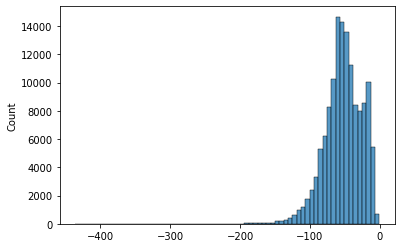

In [24]:
seaborn.histplot(data=df["feat_area_Bright"] - df["feat_convex_area_Bright"], bins=70)

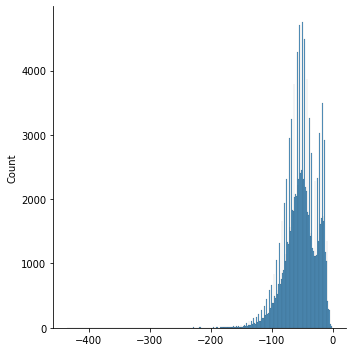

In [120]:
seaborn.displot(data=df["feat_area_Bright"] - df["feat_convex_area_Bright"])

40 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
30 A7-A7 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
25 B11-B11 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
30 B12-B12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 15.9 s, sys: 3.27 s, total: 19.2 s
Wall time: 2min 5s


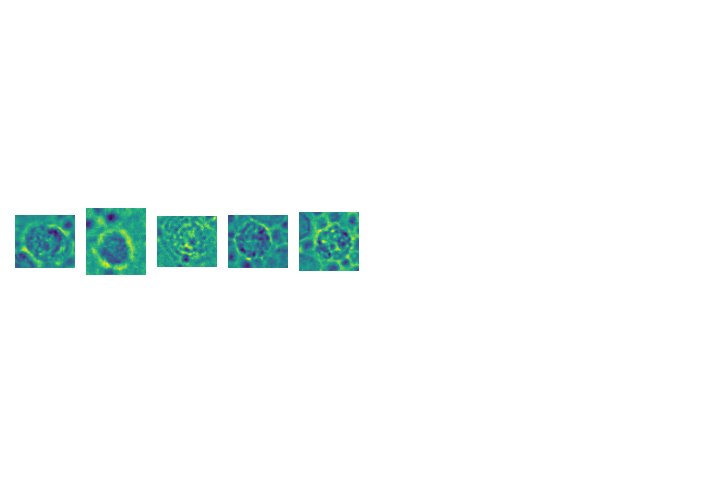

In [25]:
%%time
sel1 = (df["feat_area_Bright"] - df["feat_convex_area_Bright"]) < -100
core.plot_gate_czi(sel1, df, maxn=5, channel=3)

In [26]:
df = df[~sel1]
df.shape

(130595, 1291)

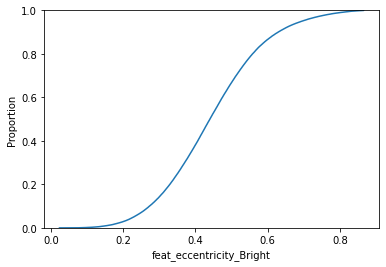

In [27]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_Bright")

13 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
22 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
24 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
10 A7-A7 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
53 B11-B11 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi


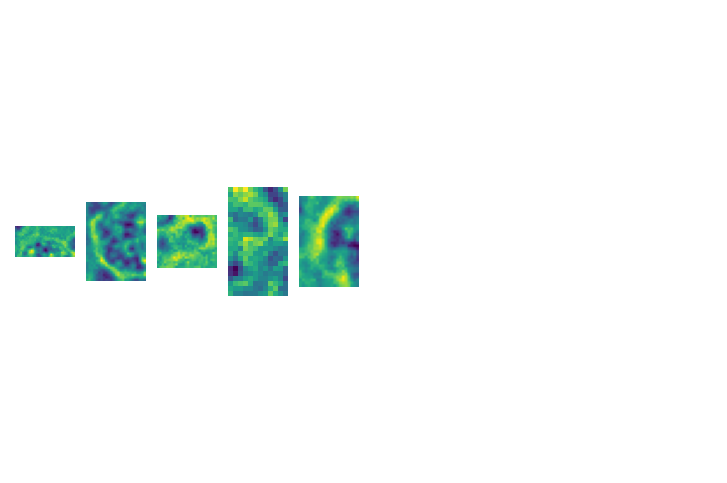

In [28]:
sel1 = df["feat_eccentricity_Bright"] > 0.75
core.plot_gate_czi(sel1, df, maxn=5, channel=3)

In [29]:
df = df[~sel1]
df.shape

(127417, 1291)

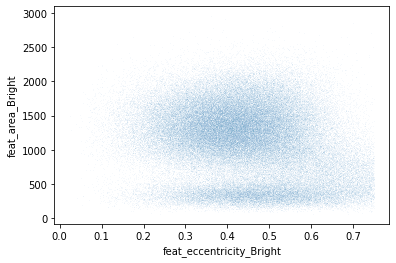

In [37]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_Bright", y="feat_area_Bright", s=0.1, alpha=0.5)

33 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
4 A11-A11 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
1 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
21 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
22 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
44 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
47 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
32 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
33 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
48 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 15.8 s, sys: 3.19 s, total: 19 s
Wall time: 1min 52s


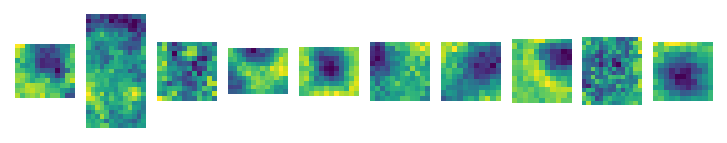

In [38]:
%%time
sel1 = df["feat_area_Bright"] < 100
core.plot_gate_czi(sel1, df, maxn=10, channel=3)

In [39]:
df = df[~sel1]
df.shape

(127243, 1291)

# Noisy events

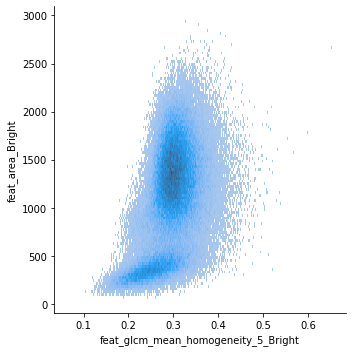

In [31]:
seaborn.displot(data=df, x="feat_glcm_mean_homogeneity_5_Bright", y="feat_area_Bright")

32 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
35 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
31 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
54 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
23 B10-B10 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 11.9 s, sys: 2.46 s, total: 14.3 s
Wall time: 1min 25s


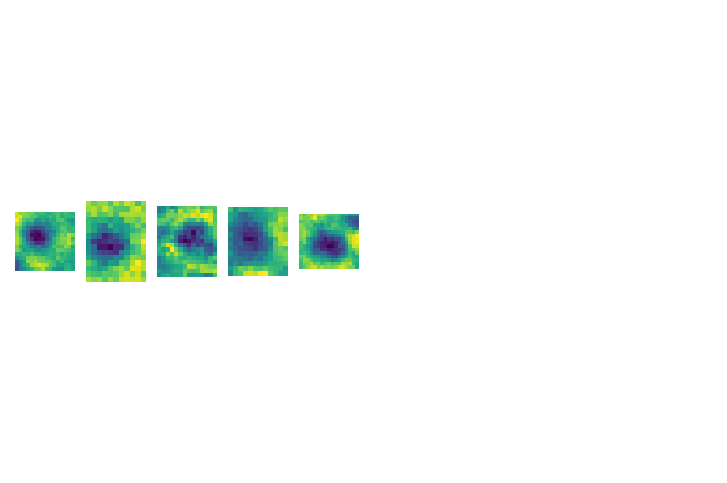

In [32]:
%%time
sel1 = df["feat_glcm_mean_homogeneity_5_Bright"] < 0.15
core.plot_gate_czi(sel1, df, maxn=5, channel=3)

In [33]:
df = df[~sel1]
df.shape

(127288, 1291)

6 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
2 A10-A10 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
40 A10-A10 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
7 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
14 A12-A12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
15 A7-A7 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
9 A8-A8 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
5 A9-A9 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
17 B12-B12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
20 B12-B12 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 27.4 s, sys: 5.5 s, total: 32.9 s
Wall time: 3min 19s


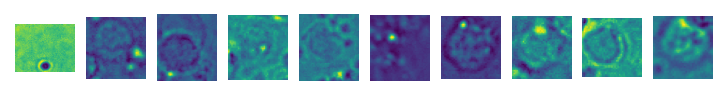

In [35]:
%%time
sel1 = df["feat_glcm_mean_homogeneity_5_Bright"] > 0.5
core.plot_gate_czi(sel1, df, maxn=10, channel=3)

In [36]:
df = df[~sel1]
df.shape

(127260, 1291)

# Distributions

In [145]:
df = df.drop(columns=df.filter(regex="feat").columns[df.filter(regex="feat").var().isna()])
df.shape

(134239, 1291)

# Feature correlation

In [70]:
correlation = df.filter(regex="feat.*").corr()

## Overall feature correlation

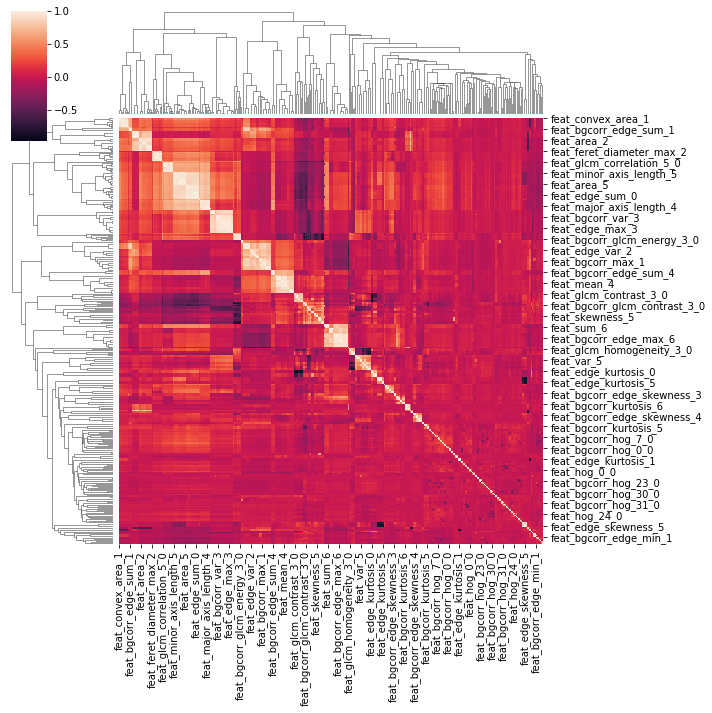

In [71]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

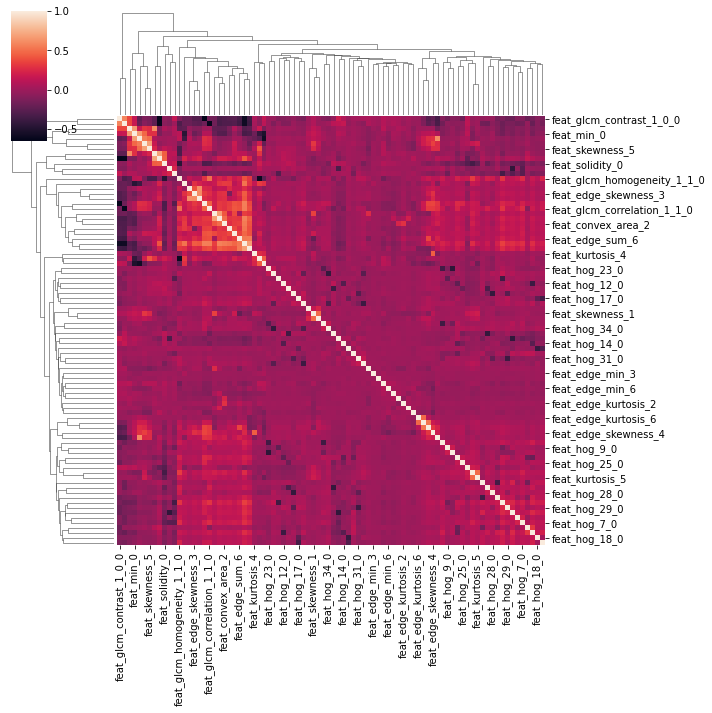

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [232]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202111301629/single_focused_index.npy", df.index.values)

In [118]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202112021107_dapi/columns.npy", df.columns.values)

In [42]:
pq.write_table(pyarrow.Table.from_pandas(df.sample(n=1000)), data_dir / "results/scip/202202172050/features_small.parquet")